# Recherche tabu

In [198]:
# math framework
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

# other Framework
from collections import deque
import random
from functools import lru_cache
from IPython.display import display, clear_output
from dataclasses import dataclass
from ipywidgets import IntProgress

# our own functions
from functions import get_vrptw_instance, show_routes

## Variables

In [199]:
# Instances
instance_name = 'C101.txt'
data_set, data_set_best_solution = get_vrptw_instance(instance_name)

# DataSET
coords = data_set['node_coord']
nb_client = len(coords) - 1

# dataSetSolution
instance_best_solution = data_set_best_solution['routes']

print(type(data_set['time_window']))
print(type(data_set['service_time']))


# Distance between two points
vertex = np.array(coords)

distance = distance_matrix(vertex, vertex)


# container of important and reusable vrp data
@dataclass
class VRPInstance:
    """
    Represents a Vehicle Routing Problem (VRP) or VRP with Time Windows (VRPTW) instance.

    Attributes:
        data_set (dict): Raw dataset loaded from a VRP instance file (e.g., from vrplib).
        nb_client (int): Number of clients (excluding the depot).
        capacity (int): Vehicle capacity limit.
        demand (List[int]): Demand value for each client.
        time_window (np.ndarray): Time windows for each client, e.g., [[a1, b1], [a2, b2], ...].
        service_time (np.ndarray): Service time required at each client.
        distance (np.ndarray): Full distance matrix between all nodes (depot + clients).
    """
    data_set: dict
    nb_client: int
    capacity: int
    demand: list[int]
    time_window: np.ndarray
    service_time: np.ndarray
    distance: np.ndarray


# Initialization
instance = VRPInstance(
    data_set=data_set,
    nb_client=nb_client,
    capacity=data_set['capacity'],
    demand=data_set['demand'],
    time_window=data_set['time_window'],
    service_time=data_set['service_time'],
    distance=distance,
)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Giant tour manipulation

In [200]:
def merge(solution):
    """
    Merge a solution into a giant list
    Args:
        solution(list[list[int]]):
            A solution of the vrp.
            With k lists of c int elements.
            With k number of routes(trucks) and c number of client in the route.
    Returns:
        giant_tour(list[int]): Merge of the all routes into a giant list.
    """
    giant_tour = []
    for route in solution:
        for city in route:
            if city != 0:
                giant_tour.append(city)
    return giant_tour



In [201]:
def split(giant_tour, instance: VRPInstance):
    """
    Split the giant tour into multiple feasible routes.
    Args:
        giant_tour (list[int]): A giant tour representing a full permutation
        of all clients.

    Returns:
        sol (list[list[int]]): A list of routes, where each route is a list
        of clients assigned to the same truck, respecting capacity constraints.
    """
    route=[]
    sol =[]
    cost = 0
    spend_time = 0
    last_client = 0
    for client in giant_tour:
        open_window = instance.time_window[client][0]
        close_window = instance.time_window[client][1]

        client_cost = instance.demand[client]
        client_service_time = instance.service_time[client]

        travel_time = instance.distance[last_client, client]

        # We chose the max between total_travel_time_for_client and open_window 
        # to simulate the waintening if we arrive before the open window.
        # SO if the truck arrive before the opening we wait until the opening
        # window so we take directely the oppening window for the arrival time
        total_travel_time_for_client = spend_time + travel_time
        arrival_time = max(open_window, total_travel_time_for_client)
        if cost + client_cost <= instance.capacity and arrival_time <= close_window:
            route.append(client)
            cost += client_cost
            spend_time = arrival_time + client_service_time
            last_client = client
        else :
            sol.append(route)

            cost = client_cost
            spend_time = instance.distance[0, client] + client_service_time
            route = [client] 
            last_client = client
    sol.append(route)

    return sol 

## random solution

In [202]:
def random_solution(nb_client, instance: VRPInstance):
    """
    Generate a random VRP solution.
    Args:
        None

    Returns:
        solution (list[list[int]]): A feasible solution composed of several routes,
        obtained by generating a random giant tour and splitting it into routes
        respecting the truck capacity constraints.
    """

    giant_tour = random.sample(range(nb_client + 1), k = nb_client + 1)
    solution = split(giant_tour, instance)
    return solution

## Neighborhood

In [203]:
def neighborhood(solution, nb_neighbors, nb_swaps_per_neighbor, instance: VRPInstance):
    """
    Find nb_neighbors solution's neighbor
    Args:
        solution(list[list[int]]):
            A solution of the vrp.
            With k lists of c int elements.
            With k number of routes(trucks) and c number of client in the route.
        nb_neighbors(int):
            number of neighbors that we want to have for the solution
        nb_swaps_per_neighbor(int):
            number of swap per neighbor.
            if nb_swaps_per_neighbor = 1 we swap 2 values between them
            if nb_swaps_per_neighbor = 2 we swap two time 2 differente values between them
    Returns:
        neighbors(list[solution]):
            list of nb_neighbors solution's neighbor
    """
    neighbors = []

    giant_tour = merge(solution)
    size_giant_tour = len(giant_tour)

    i, j = random.sample(range(size_giant_tour), 2)
    for _ in range(nb_neighbors):
        neighbor_giant_tour = giant_tour.copy()
        for _ in range(nb_swaps_per_neighbor):
            i, j = random.sample(range(size_giant_tour), 2)
            neighbor_giant_tour[i], neighbor_giant_tour[j] = neighbor_giant_tour[j], neighbor_giant_tour[i]
        neighbors.append(split(neighbor_giant_tour, instance))
    return neighbors

## Weights evaluation

In [204]:
def total_travel_distance(solution, instance: VRPInstance):
    """
    Compute the total distance travelled by all trucks.

    Args:
        solution (list[list[int]]): Set of routes, where each route lists the clients
            visited by a truck, without the depot.

    Returns:
        float: Sum of the distances for every leg of every route, including depot
            departure and return.
    """
    total_distance = 0
    for route in solution:
        full_route = [0] + route + [0]
        for j in range(len(full_route) - 1):
            origin = full_route[j]
            destination = full_route[j + 1]
            total_distance += instance.distance[origin, destination]
    return total_distance

## Tabu search

In [205]:
def tabu_search(instance: VRPInstance, initial_solution, tabu_size, iter_max, nb_neighbors, nb_swaps_per_neighbor, speed_graphic=0, show_graphic=False):
    """
    Perform a Tabu Search to improve a VRP solution.

    Args:
        initial_solution (list[list[int]]): Starting set of routes.
        tabu_size (int): Maximum number of solutions remembered in the tabu list.
        iter_max (int): Number of iterations allowed without improvement before stop.
        nb_neighbors (int): Number of neighbor per solution
        nb_swaps_per_neighbor (int): number of swap to obtain a naighbor
        speed_graphic (int): speed of the graph display
        show_graphic (bool): activate or no the graph display
    Returns:
        list[list[int]]: Best solution found during the search.
    """
    nb_iter = 0

    tabu_list = deque(maxlen=tabu_size)

    current_solution = initial_solution
    global_best_solution = initial_solution
    value_best_global = total_travel_distance(initial_solution, instance)

    graphic_tic = 0
    while nb_iter < iter_max:
        neighbors = neighborhood(current_solution, nb_neighbors, nb_swaps_per_neighbor, instance)
        
        best_neighbor = None
        best_neighbor_distance = float('inf')
        
        for neighbor in neighbors:
            neighbor_distance = total_travel_distance(neighbor, instance)
            neighbor_hash = tuple(sorted(tuple(route) for route in neighbor))
            
            if neighbor_hash not in tabu_list or neighbor_distance < value_best_global:
                if neighbor_distance < best_neighbor_distance:
                    best_neighbor_distance = neighbor_distance
                    best_neighbor = neighbor

        if best_neighbor is None:
            break
            
        current_solution = best_neighbor
        current_hash = tuple(sorted(tuple(route) for route in current_solution))
        tabu_list.append(current_hash)

        # Update global best if improved
        if best_neighbor_distance < value_best_global:
            global_best_solution = best_neighbor
            value_best_global = best_neighbor_distance
            nb_iter = 0
        else:
            nb_iter += 1

        # Graph display
        if show_graphic and graphic_tic >= speed_graphic:
            clear_output(wait=True)
            print(f"Iteration: {nb_iter} | Best Distance: {value_best_global:.2f}")
            show_routes(current_solution, instance.data_set)
            plt.close()
            graphic_tic = 0
        
        if show_graphic:
            graphic_tic += 1
  
    return global_best_solution


In [206]:
# importantes variables for tabu search
tabu_size = int(np.sqrt(instance.nb_client))
nb_iter = 200
nb_neighbors = 50
nb_swaps_per_neighbor = 1

best_score = float('inf')
best_solution = None

random.seed(3)

# Tabu search with multi start
for _ in range(10):
    cur = random_solution(instance.nb_client, instance)
    cur = tabu_search(instance, cur, tabu_size, nb_iter, nb_neighbors, nb_swaps_per_neighbor)
    cur_score = total_travel_distance(cur, instance)
    if cur_score < best_score:
        best_score = cur_score
        best_solution = cur

distance_best = total_travel_distance(instance_best_solution, instance)
distance_tabu = total_travel_distance(best_solution, instance)

print(f"Upper bound: {distance_best}")
print(f"Tabu best: {distance_tabu}")

gap = (distance_tabu - distance_best) / distance_best * 100
print(f"Gap: {gap:.2f}%")

print(len(best_solution))



Upper bound: 828.9368669428343
Tabu best: 1711.0161301075623
Gap: 106.41%
23


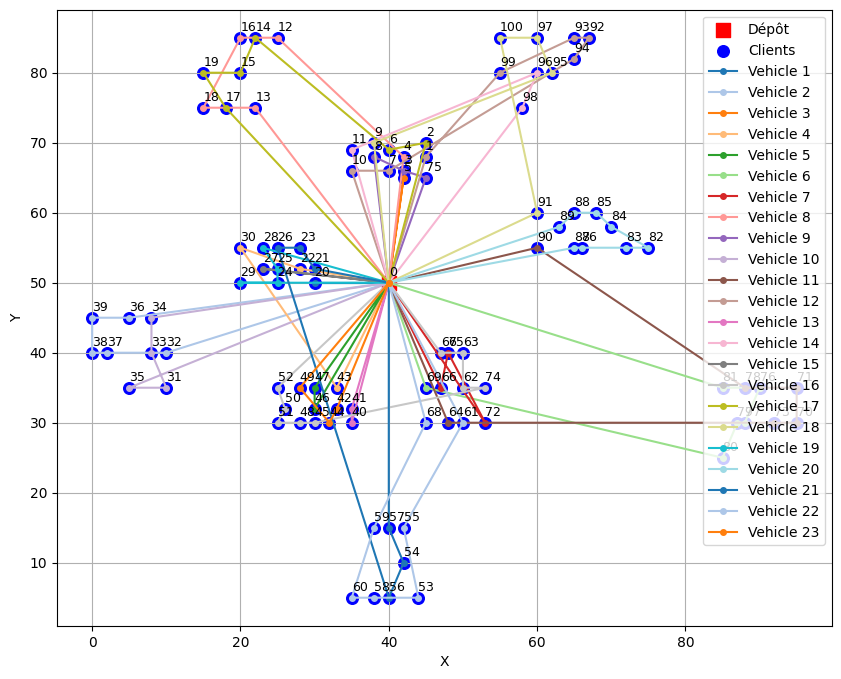

23


In [207]:
show_routes(best_solution, data_set)

print(len(best_solution))


# Test


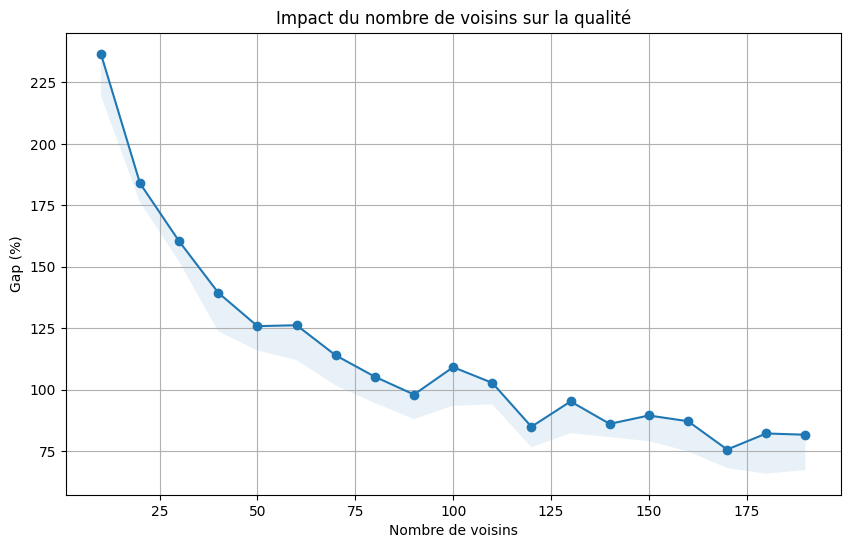

In [208]:
# number of neighboor test

# Variables
nb_neighbors_max = 200
step = 10
nb_iter = 100
tabu_size = int(np.sqrt(instance.nb_client))
nb_tests = 10

# initialization
ini_solution_test = random_solution(instance.nb_client, instance)
avg_neighbors_gap = []
deviation_neighbors_gap = []
nb_neighbors_values = []
distance_best = total_travel_distance(instance_best_solution, instance)

bar = IntProgress(min=0, max=nb_neighbors_max, layout={"width" : "100%"})
display(bar)

for i in range(step, nb_neighbors_max, step):
    neighbors_gap = []

    bar1 = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
    display(bar1)
    for _ in range(nb_tests):
        
        # Use ini_solution_test to start from the same initial solution each time
        test = tabu_search(instance, ini_solution_test, tabu_size, nb_iter, i, nb_swaps_per_neighbor)

        distance_test = total_travel_distance(test, instance)
        gap = (distance_test - distance_best) / distance_best * 100

        neighbors_gap.append(gap)

        bar1.value += 1

    bar1.close()
    bar.value += step

    nb_neighbors_values.append(i)

    avg_neighbors_gap.append(np.mean(neighbors_gap))
    deviation_neighbors_gap.append(np.std(neighbors_gap))

    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(nb_neighbors_values, avg_neighbors_gap, marker='o')
    plt.fill_between(nb_neighbors_values, avg_neighbors_gap, np.subtract(avg_neighbors_gap, deviation_neighbors_gap), alpha=.1)
    plt.xlabel('Nombre de voisins')
    plt.ylabel('Gap (%)')
    plt.title('Impact du nombre de voisins sur la qualité')
    plt.grid(True)
    plt.show()

bar.close()
